# Exoplanet Atmospheric Analysis

**Author:** Jackson Ferguson

**Objective:** To characterize the atmospheric structure, composition, and stability of a high-gravity exoplanet ($g = 20 \, \text{m/s}^2$) using telemetry data from five descent probes.

**Key Analyses:**
1.  **Composition:** Derivation of mean molar mass and constituent mass fractions.
2.  **Hydrostatic Equilibrium:** Verification of stability via vertical pressure gradients.
3.  **Thermodynamics:** Analysis of potential temperature ($\theta$), lapse rates ($\Gamma_d$), and specific heat ($C_p$).
4.  **Hydrology:** Estimation of precipitable water content and global precipitation rates.
5.  **Radiative Transfer:** Calculation of optical depth ($\tau$) for $CO_2$ and $H_2$O.

## 1. Environment Setup & Data Ingestion
We begin by initializing the scientific Python environment and defining the core physical constants governing the exoplanet ($g = 20 \, \text{m/s}^2$). Visual configurations are set to ensure all subsequent plots meet publication standards.

In [1]:
# For saving figures
from pathlib import Path

# Standard scientific libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import Avogadro, R

# Configure plot aesthetics for academic presentation
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.figsize": (10, 6),
        "lines.linewidth": 2.0,
        "axes.grid": True,
        "grid.alpha": 0.5,
    }
)

# Directory to save figures
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

### Physical Constants & Parameters
We define the core physical constants governing the exoplanet and its atmospheric constituents. This central configuration ensures consistency across all subsequent thermodynamic and radiative transfer calculations.

In [2]:
# --- Planetary Parameters ---
g = 20.0  # Surface gravity [m/s^2]
R_PLANET = 6371e3  # Planetary radius [m] (Assumed Earth-like for surface area)

# --- Chemical Properties ---
# Molar masses for constituent gases [g/mol]
MOLAR_MASS = {
    "N2": 28.0134,
    "He": 4.002602,
    "Ar": 39.948,
    "CO2": 44.01,
    "H2O": 18.01528,
}

# Specific heat capacities [J/(kg K)]
# CO2 and H2O are approximated; N2/He/Ar treated as ideal gases in calculation
CP_CONSTANTS = {"CO2": 850.0, "H2O": 1870.0}

# --- Water Vapor Thermodynamics ---
L_VAPORIZATION = 2.5e6  # Latent heat of vaporization [J/kg]
R_WATER_VAPOR = 461.5  # Specific gas constant for water vapor [J/(kg K)]
HUMIDITY_THRESHOLD = 0.0005  # Noise floor for specific humidity measurements

# --- Radiative Transfer ---
# Absorption cross-sections [m^2/molecule]
SIGMA_ABS = {"H2O": 2e-27, "CO2": 1.2e-28}
SIGMA_H2O_SPECIFIC = 7.5e-29  # Cross-section for targeted band analysis

# Reference levels for optical depth integration [hPa]
PRESSURE_LEVELS = [1250, 750, 500, 350, 200]
TARGET_PRESSURE = 450.0  # Level for targeted sensitivity analysis

# --- Energy Budget & Uncertainty ---
ABSORBED_SW_FLUX = 150.0  # Absorbed shortwave flux [W/m^2]
LATENT_HEAT_FRAC = 0.4  # Fraction of energy driving evaporation

# Absolute uncertainty estimates for error propagation
U_SW_FLUX = 10.0  # [W/m^2]
U_LH_FRAC = 0.05  # [dimensionless]
U_L_VAP = 0.1e6  # [J/kg]

In [3]:
# -----------------------------------------------------------------------------
# Data Loading Functions
# -----------------------------------------------------------------------------


def load_probe_data(filepath):
    """
    Loads atmospheric telemetry data from a text file.
    Returns the transposed array for easy unpacking.
    """
    try:
        return np.loadtxt(filepath, skiprows=12).T
    except OSError:
        print(f"Error: Could not find file '{filepath}'. Please check the path.")
        return None


def get_probe_indices(probe_ids):
    """
    Finds the array indices corresponding to each of the 5 probes.
    """
    indices = {}
    for i in range(1, 6):
        # np.where returns a tuple; we extract the first element (the array)
        indices[i] = np.where(probe_ids == i)[0]
    return indices


# -----------------------------------------------------------------------------
# Atmospheric Physics Functions (Composition & Density)
# -----------------------------------------------------------------------------


def calculate_mass_density(n_scaled, molar_mass_g):
    """
    Converts number density (n * 10^22 m^-3) to mass density (kg/m^3).
    """
    # Factor 1e22 is from data scaling
    # Factor 1e-3 converts g/mol to kg/mol
    return (n_scaled * 1e22) * (molar_mass_g * 1e-3) / Avogadro


# -----------------------------------------------------------------------------
# Thermodynamic Functions (Temperature, Humidity, Stability)
# -----------------------------------------------------------------------------


def reconstruct_temperature(pressure_pa, density_kg, molar_mass_kg, dp_dz_pa):
    """
    Derives Temperature from the Hydrostatic Equation:
    T = - (M * P * g) / (R * dp/dz)
    """
    # Note: R is the universal gas constant (8.314)
    numerator = -1 * molar_mass_kg * pressure_pa * g
    denominator = R * dp_dz_pa
    return numerator / denominator


def calculate_relative_humidity(temp_k, vapor_rho_kg, pressure_pa):
    """
    Calculates Relative Humidity using Ideal Gas Law and Clausius-Clapeyron.
    """
    # 1. Actual Vapor Pressure (e) [Pa] via Ideal Gas Law: e = rho_v * R_v * T
    e = vapor_rho_kg * R_WATER_VAPOR * temp_k

    # 2. Saturation Vapor Pressure (es) [Pa] via Clausius-Clapeyron
    # Base reference: 611 Pa at 273.15 K
    T0 = 273.15
    exponent = (L_VAPORIZATION / R_WATER_VAPOR) * ((1 / T0) - (1 / temp_k))
    es = 611 * np.exp(exponent)

    # 3. Relative Humidity [%]
    return (e / es) * 100.0


def calculate_ideal_gas_cp(molar_mass_g, degrees_of_freedom):
    """
    Calculates specific heat capacity for an ideal gas.
    Formula: Cp = (f/2 + 1) * R_specific = (f/2 + 1) * R / M

    Args:
        molar_mass_g: Molar mass in g/mol
        degrees_of_freedom (f):
            - 5 for Diatomic (N2, O2) -> Cp = 7/2 R/M
            - 3 for Monatomic (He, Ar) -> Cp = 5/2 R/M
    """
    # Convert M to kg/mol
    molar_mass_kg = molar_mass_g * 1e-3

    # Pre-factor (f+2)/2 corresponds to 7/2 or 5/2
    factor = (degrees_of_freedom + 2) / 2
    return factor * R / molar_mass_kg


# -----------------------------------------------------------------------------
# Hydrology Functions (Precipitable Water)
# -----------------------------------------------------------------------------


def calculate_precipitable_water(specific_humidity, pressure_hpa, g, probe_indices_map):
    """
    Integrates specific humidity profile to find total water column mass.
    Returns a dictionary of results for each probe.
    """
    results = {}

    # Convert Pressure to Pascals for the integral
    pressure_pa = pressure_hpa * 100.0

    for name, indices in probe_indices_map.items():
        # Extract data for this probe
        q_segment = specific_humidity[indices]
        p_segment = pressure_pa[indices]

        # Integrate q * dp / g
        # We use the absolute value because integration from Surface->Top (decreasing P)
        # yields a negative result naturally.
        integral = np.trapezoid(q_segment, x=p_segment)
        pwv_kg_m2 = np.abs(integral / g)

        results[name] = pwv_kg_m2

    return results


def calculate_global_water_cycle(pwv_data, sw_flux, lh_frac, l_v):
    """
    Computes precipitation rate, residence time, and propagates uncertainties.
    """
    # --- A. Precipitation Rate ---
    # Rate [kg/m^2/s] = (W/m^2) / (J/kg)
    precip_flux_kg = (sw_flux * lh_frac) / l_v

    # Convert to mm/hour
    # 1 kg/m^2 = 1 mm depth
    precip_mm_hr = precip_flux_kg * 3600.0

    # --- B. Residence Time ---
    # Tau = Total Mass / Total Flux
    # Note: Surface Area cancels out, so Tau = Mean_PWV / Precip_Flux

    # Get mean PWV [kg/m^2] from our refined analysis (Cell 8)
    pwv_values = np.array(list(pwv_data.values()))
    mean_pwv = np.mean(pwv_values)

    # Tau [seconds]
    tau_seconds = mean_pwv / precip_flux_kg
    tau_days = tau_seconds / (24 * 3600)

    return precip_mm_hr, tau_days, pwv_values


# -----------------------------------------------------------------------------
# Radiative Transfer Functions (Optical Depth)
# -----------------------------------------------------------------------------


def calculate_extinction_coefficients(vapor_rho, co2_n_scaled):
    """
    Calculates extinction coefficients (beta) [m^-1].
    beta = sigma * n
    """
    # 1. H2O: Convert Mass Density (kg/m^3) -> Number Density (m^-3)
    # n = (rho * N_A) / M
    M_h2o_kg = MOLAR_MASS["H2O"] * 1e-3
    n_h2o = (vapor_rho * Avogadro) / M_h2o_kg
    beta_h2o = SIGMA_ABS["H2O"] * n_h2o

    # 2. CO2: Unscale Number Density (10^22 m^-3 -> m^-3)
    n_co2 = co2_n_scaled * 1e22
    beta_co2 = SIGMA_ABS["CO2"] * n_co2

    return beta_h2o, beta_co2


def integrate_optical_depth(beta, rho_air, pressure_hpa, limit_p):
    """
    Integrates optical depth from top of atmosphere down to pressure level P.
    tau = Integral( beta / (rho_air * g) ) dp
    """
    # Select atmospheric layer above the pressure level P
    # (Assuming data includes top of atmosphere, we filter for p_local <= P_target)
    mask = pressure_hpa <= limit_p

    if np.sum(mask) < 2:
        return 0.0

    # Extract segments
    beta_seg = beta[mask]
    rho_seg = rho_air[mask]
    p_seg_pa = pressure_hpa[mask] * 100.0  # Convert to Pa for integration

    # Integrand: beta / (rho * g)
    # Note: Using global 'g' (20 m/s^2)
    integrand = beta_seg / (rho_seg * g)

    # Trapezoidal integration
    return np.trapezoid(integrand, p_seg_pa)


# -----------------------------------------------------------------------------
# Visualization & Reporting Helpers
# -----------------------------------------------------------------------------


def print_pwv_report(results):
    """
    Prints a formatted ASCII table of the results.
    """
    print("\n" + "=" * 60)
    print(f"{'PROBE':<10} | {'MASS (kg/m²)':>15} | {'DEPTH (cm)':>15}")
    print("=" * 60)

    # Collect values for summary stats
    values = []

    for name, mass in results.items():
        # Equivalent depth of liquid water (rho_water ~ 1000 kg/m^3)
        # Depth [m] = Mass [kg/m^2] / 1000 [kg/m^3]
        # Depth [cm] = Depth [m] * 100
        depth_cm = (mass / 1000.0) * 100.0
        values.append(mass)

        # Use the probe ID (e.g., 1 from 'Probe 1') for the table
        print(f"Probe {name:<4} | {mass:>15.2f} | {depth_cm:>15.2f}")

    print("-" * 60)
    print(f"{'MEAN':<10} | {np.mean(values):>15.2f} | {(np.mean(values) / 10):>15.2f}")
    print(f"{'STD DEV':<10} | {np.std(values):>15.2f} | {(np.std(values) / 10):>15.2f}")
    print("=" * 60 + "\n")


def compute_rh_profile(temp_k, vapor_rho_kg, pressure_hpa, molar_masses):
    """
    Computes partial pressure (e) and saturation pressure (es) to find RH.
    """
    # Constants for Clausius-Clapeyron (Water)
    L_V = 2.5e6  # Latent heat of vaporization [J/kg]
    R_GAS = 8.314  # Universal gas constant
    M_W = molar_masses["H2O"] * 1e-3  # kg/mol (0.018)
    R_V = R_GAS / M_W  # Specific gas constant for water vapor

    # 1. Actual Vapor Pressure (e) via Ideal Gas Law: P = rho * R_specific * T
    # e [Pa] = rho_v [kg/m^3] * R_v [J/kgK] * T [K]
    e = vapor_rho_kg * R_V * temp_k

    # 2. Saturation Vapor Pressure (es)
    # es = 611 * exp( (L_v/R_v) * (1/273 - 1/T) )
    T0 = 273.15
    exponent = (L_V / R_V) * ((1 / T0) - (1 / temp_k))
    es = 611.0 * np.exp(exponent)

    # 3. Relative Humidity
    # Protect against division by zero if es is extremely small
    rh = np.zeros_like(e)
    mask = es > 0
    rh[mask] = (e[mask] / es[mask]) * 100.0

    return rh


def plot_humidity_profiles(rh_data, pressure_data, probe_map):
    """
    Plots vertical RH profiles for all probes.
    """
    fig, ax = plt.subplots(figsize=(8, 10))

    colors = ["#000000", "#d62728", "#1f77b4", "#9467bd", "#e377c2"]

    for i, (probe_id, indices) in enumerate(probe_map.items()):
        # Filter out non-physical noise (e.g. RH > 150% or < 0%) for cleaner plots
        # We just clip for visualization or mask
        p_seg = pressure_data[indices]
        rh_seg = rh_data[indices]

        # Plot
        ax.scatter(
            rh_seg,
            p_seg,
            s=10,
            alpha=0.6,
            label=f"Probe {probe_id}",
            color=colors[i % len(colors)],
        )

    ax.set_xlabel("Relative Humidity (%)")
    ax.set_ylabel("Pressure [hPa]")
    ax.set_title("Atmospheric Relative Humidity Profiles")

    # Standard atmosphere plot convention: Pressure decreases upwards (so Y is inverted)
    ax.invert_yaxis()
    ax.set_xlim(55, 180)
    ax.legend(frameon=True, framealpha=0.9, markerscale=2)

    plt.tight_layout()

    fig.savefig(fig_dir / "relative_humidity_vs_pressure.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "relative_humidity_vs_pressure.svg", bbox_inches="tight")

    plt.show()


def print_optical_depth_table(species_name, data_dict):
    print(f"\n{'=' * 70}")
    print(f"\033[1m{species_name} Optical Depth\033[0m")
    print(f"{'=' * 70}")

    # Header
    print(f"{'Pressure (hPa)':<16}", end="")
    for i in range(1, 6):
        print(f"{'Probe ' + str(i):>12}", end="")
    print()
    print("-" * 70)

    # Rows
    for p in PRESSURE_LEVELS:
        print(f"{p:<16}", end="")
        row_values = data_dict[p]

        for val in row_values:
            if val < 1e-5:
                print(f"{val:>12.2e}", end="")
            else:
                print(f"{val:>12.4f}", end="")
        print()  # Newline

    print()  # Spacing

### Data Ingestion
The telemetry data from the five descent probes is loaded from raw text files. We generate specific index maps for each probe to allow for individual trajectory analysis later in the pipeline.

In [4]:
# 1. Load Data
# Import telemetry data from source file
filepath = "data/exoplanet_data.txt"
data = load_probe_data(filepath)

# Decompose data matrix into constituent state vectors
(
    probe_number,
    pressure,
    temperature,
    air_density,
    n2_density_molecules,
    he_density_molecules,
    ar_density_molecules,
    co2_density_molecules,
    altitude,
) = data

# 2. Generate Indices
# Create index masks for individual probe identification
probe_idx_map = get_probe_indices(probe_number)

# Isolate indices for specific probes
probe1, probe2, probe3, probe4, probe5 = (probe_idx_map[i] for i in range(1, 6))

# 3. Define Start/End Indices for convenient slicing
# Determine index boundaries for each probe trajectory
probe1_start, probe1_end = probe_idx_map[1][0], probe_idx_map[1][-1]
probe2_start, probe2_end = probe_idx_map[2][0], probe_idx_map[2][-1]
probe3_start, probe3_end = probe_idx_map[3][0], probe_idx_map[3][-1]
probe4_start, probe4_end = probe_idx_map[4][0], probe_idx_map[4][-1]
probe5_start, probe5_end = probe_idx_map[5][0], probe_idx_map[5][-1]

# Verify data integrity and altitude range
print(f"Telemetry Loaded: {len(altitude)} data points total.")
print(
    f"Probe 1 Altitude Range: {altitude[probe1_start]:.1f}m -> {altitude[probe1_end]:.1f}m"
)

Telemetry Loaded: 4505 data points total.
Probe 1 Altitude Range: 11240.1m -> 0.0m


## 2. Atmospheric Composition
To model the thermodynamics of the atmosphere, we first convert the measured number densities ($n$) into mass densities ($\rho$). Using the known molar masses of the constituents (N$_2$, He, Ar, CO$_2$, H$_2$O), we determine the mass fraction $f_i$ of each species.

The **Mean Molar Mass** ($\mu$) of the mixture is calculated as the harmonic mean of the constituents:
$$\frac{1}{\mu} = \sum \frac{f_i}{M_i}$$

In [5]:
# -----------------------------------------------------------------------------
# 2. Atmospheric Composition Analysis
# -----------------------------------------------------------------------------

# 1. Calculate Mass Densities [kg/m^3]
# Convert number densities (scaled) to mass densities
n2_rho = calculate_mass_density(n2_density_molecules, MOLAR_MASS["N2"])
he_rho = calculate_mass_density(he_density_molecules, MOLAR_MASS["He"])
ar_rho = calculate_mass_density(ar_density_molecules, MOLAR_MASS["Ar"])
co2_rho = calculate_mass_density(co2_density_molecules, MOLAR_MASS["CO2"])

# 2. Calculate Mass Fractions
# Compute mass fractions ($f_i = \rho_i / \rho_{total}$)
n2_frac = n2_rho / air_density
he_frac = he_rho / air_density
ar_frac = ar_rho / air_density
co2_frac = co2_rho / air_density

# 3. Infer Water Vapor (Residual)
# Derive water vapor density as the residual of total air density
vapor_rho = air_density - (n2_rho + he_rho + ar_rho + co2_rho)
vapor_frac = vapor_rho / air_density
specific_humidity = vapor_rho / air_density

# 4. Calculate Mixture Mean Molar Mass [g/mol]
# Calculate mean molar mass via harmonic mean of constituents
sum_ratios = (
    (n2_frac / MOLAR_MASS["N2"])
    + (he_frac / MOLAR_MASS["He"])
    + (ar_frac / MOLAR_MASS["Ar"])
    + (co2_frac / MOLAR_MASS["CO2"])
    + (vapor_frac / MOLAR_MASS["H2O"])
)
mix_molar_mass = 1.0 / sum_ratios

# Output derived parameters for verification
print("Composition Calculated.")
print(
    f"Mean Molar Mass range: {np.min(mix_molar_mass):.2f} - {np.max(mix_molar_mass):.2f} g/mol"
)

Composition Calculated.
Mean Molar Mass range: 19.72 - 19.77 g/mol


## 3. Hydrostatic Equilibrium Analysis
We evaluate the mechanical stability of the atmosphere by comparing the vertical pressure gradient to the theoretical hydrostatic expectation.

We calculate the vertical pressure gradient $\frac{dp}{dz}$ using centered finite differences. If the atmosphere is in hydrostatic balance, it must satisfy:
$$\frac{dp}{dz} = -\rho g = -\frac{P \cdot \mu}{R \cdot T} g$$
We perform a linear regression of Pressure ($P$) against the gradient term for each probe to verify this relationship.

In [6]:
# -----------------------------------------------------------------------------
# 3a. Hydrostatic Equilibrium: Dynamics & Fitting
# -----------------------------------------------------------------------------

# 1. Calculate Vertical Pressure Gradient (dp/dz)
# Compute vertical pressure gradient using centered finite differences
# Discretization scheme: (P[i+1] - P[i-1]) / (z[i+1] - z[i-1])
# Adjust array boundaries to account for finite difference stencil
delta_z = altitude[2:] - altitude[:-2]  # [m]
delta_p = pressure[2:] - pressure[:-2] * 100  # [Pa] (hPa -> Pa)

# Gradient in [Pa/m]
dp_dz = delta_p / delta_z

# 2. Check Hydrostatic Balance
# Evaluate hydrostatic equilibrium condition
# Calculate ratio of pressure gradient forces to gravitational forces
# Theoretical term: - (dp/dz * R * T) / (M_mix * P * g)
# Align state arrays with gradient vector dimensions
_T_sliced = temperature[1:-1]
_P_sliced = pressure[1:-1] * 100  # Pa
_M_sliced = mix_molar_mass[1:-1] / 1000  # kg/mol

equilibrium_ratio = (-dp_dz * R * _T_sliced) / (_M_sliced * _P_sliced * g)

# 3. Perform Linear Regression for each Probe
# Define analysis segments for each probe
# Using a dict to store results keeps the workspace clean
probe_segments = {
    "Probe 1": (slice(0, 899), slice(1, 900)),
    "Probe 3": (slice(1802, 2701), slice(1803, 2702)),
    "Probe 4": (slice(2703, 3602), slice(2704, 3603)),
    "Probe 5": (slice(3604, 4503), slice(3604, 4503)),
}

fit_results = {}

for name, (dp_slice, p_slice) in probe_segments.items():
    # Extract segments
    x_data = dp_dz[dp_slice]
    y_data = pressure[p_slice]

    # Fit linear model: P = m * (dp/dz) + c
    slope, intercept = np.polyfit(x_data, y_data, 1)

    # Calculate Statistics (Standard Error)
    # Predict y based on fit
    y_pred = slope * x_data + intercept
    residuals = y_data - y_pred

    # Calculate standard error of the slope
    n = len(x_data)
    s_err = np.sqrt(np.sum(residuals**2) / (n - 2)) / np.sqrt(
        np.sum((x_data - np.mean(x_data)) ** 2)
    )

    # Store regression results for visualization
    fit_results[name] = {
        "slope": slope,
        "intercept": intercept,
        "std_err": s_err,
        "x": x_data,
        "y": y_data,
        "y_pred": y_pred,
    }

print("Hydrostatic regressions complete.")

Hydrostatic regressions complete.


### Hydrostatic Verification Plot
We visualize the linear regression of the hydrostatic terms. A tight linear fit ($R^2 \approx 1$) confirms that the atmosphere is stable and not subject to significant vertical accelerations (winds/turbulence) at these scales.

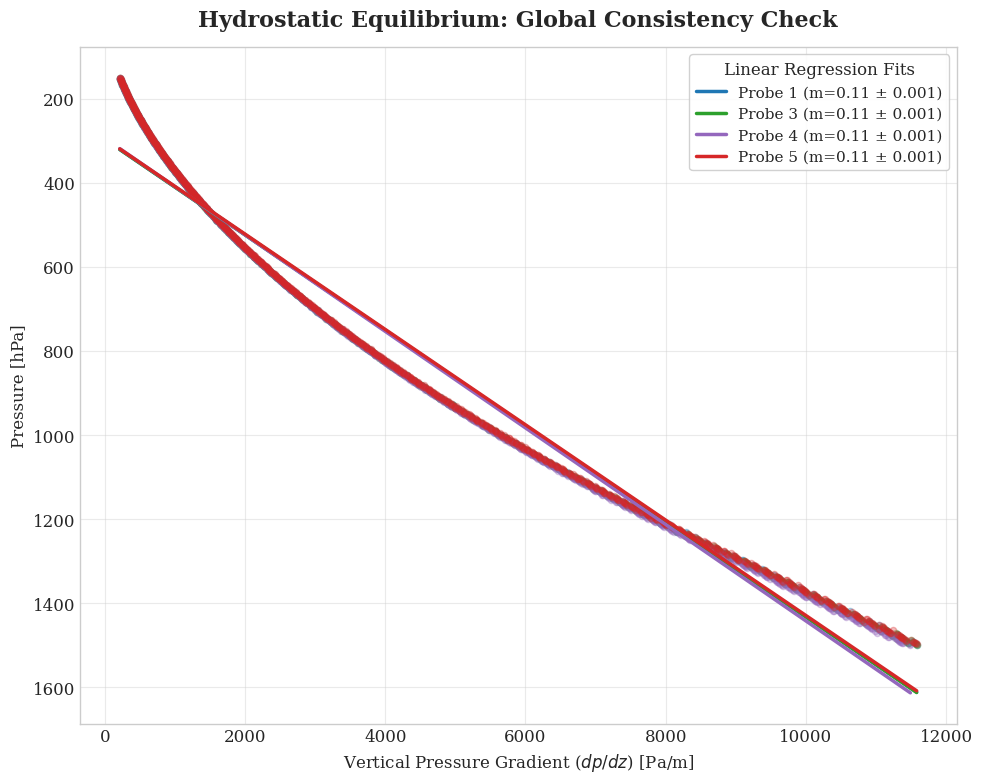

In [7]:
# -----------------------------------------------------------------------------
# 4b. Hydrostatic Equilibrium: Visualization
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 8))

# Color palette for distinct probes
colors = ["#1f77b4", "#2ca02c", "#9467bd", "#d62728"]

for i, (name, res) in enumerate(fit_results.items()):
    # Unpack regression results
    x = res["x"]
    y = res["y"]
    y_fit = res["y_pred"]

    # Label includes the slope for quantitative comparison
    label_str = f"{name} (m={res['slope']:.2f} ± {res['std_err']:.3f})"

    # Plot Data (lighter alpha to see overlap)
    ax.scatter(x, y, s=20, color=colors[i], alpha=0.3)

    # Plot Fit Line
    ax.plot(x, y_fit, color=colors[i], linewidth=2.5, label=label_str)

# Aesthetics
ax.set_title(
    "Hydrostatic Equilibrium: Global Consistency Check",
    fontsize=16,
    fontweight="bold",
    pad=15,
)
ax.set_xlabel("Vertical Pressure Gradient ($dp/dz$) [Pa/m]", fontsize=12)
ax.set_ylabel("Pressure [hPa]", fontsize=12)

# Invert Y-axis to match atmospheric vertical profile (surface at bottom)
ax.invert_yaxis()

# Grid and Legend
ax.grid(True, alpha=0.4)
ax.legend(
    loc="best",
    frameon=True,
    framealpha=0.9,
    fontsize=11,
    title="Linear Regression Fits",
)

plt.tight_layout()

fig.savefig(fig_dir / "hydrostatic_equilibrium.pdf", bbox_inches="tight")
fig.savefig(fig_dir / "hydrostatic_equilibrium.svg", bbox_inches="tight")

plt.show()

## 4. Thermodynamics: Temperature Reconstruction & Humidity
**Probe 2** experienced a sensor failure resulting in missing temperature data. We reconstruct this profile by inverting the hydrostatic equation derived in the previous step:
$$T(z)_{rec} = - \frac{\mu(z) \cdot g \cdot P(z)}{R \cdot \frac{dp}{dz}}$$

With the complete temperature profile, we calculate the **Relative Humidity (RH)**. We derive the Saturation Vapor Pressure ($e_s$) using the **Clausius-Clapeyron** relation and compare it to the actual vapor pressure ($e$) derived from the ideal gas law:
$$RH = \frac{e}{e_s(T)} \times 100\%$$

In [8]:
# -----------------------------------------------------------------------------
# 4a. Thermodynamics Analysis
# -----------------------------------------------------------------------------

# 1. Reconstruct Probe 2 Temperature
# Isolate Probe 2 data range
p2_slice = slice(probe2_start, probe2_end)

_z_p2 = altitude[p2_slice]
_p_p2 = pressure[p2_slice] * 100  # Convert to Pascals
_rho_p2 = air_density[p2_slice]

# Calculate local vertical gradients using finite differences
_dz = np.gradient(_z_p2)
_dp = np.gradient(_p_p2)
_dp_dz_p2 = _dp / _dz

# Derive temperature profile from hydrostatic balance
T_reconstructed = reconstruct_temperature(
    _p_p2,
    _rho_p2,
    mix_molar_mass[p2_slice] / 1000,  # Convert to kg/mol
    _dp_dz_p2,
)

# Integrate reconstructed data into the primary temperature array
temperature[p2_slice] = T_reconstructed

# 2. Calculate Global Humidity
# Compute Relative Humidity for all probes using the complete temperature dataset
RH = calculate_relative_humidity(temperature, vapor_rho, pressure * 100)

# Verify reconstruction and humidity calculation
print("Thermodynamics Updated.")
print(f"Probe 2 Mean Temp Reconstructed: {np.mean(T_reconstructed):.2f} K")
print(f"Global Mean RH: {np.mean(RH):.2f}%")

Thermodynamics Updated.
Probe 2 Mean Temp Reconstructed: 255.27 K
Global Mean RH: 3582.96%


### Humidity Profile Visualization
We plot the raw Relative Humidity profiles. Note that sensor noise or transient effects may result in unphysical values (e.g., RH < 0% or localized spikes), which will be filtered in the next step.

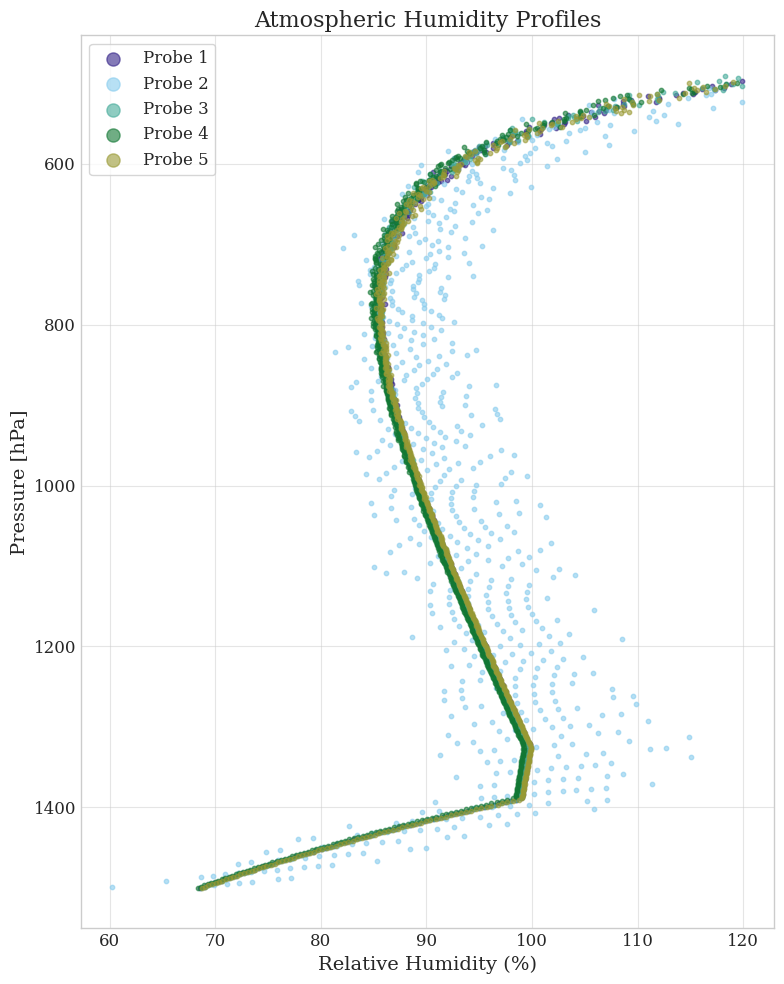

In [9]:
# -----------------------------------------------------------------------------
# 4b. Humidity Visualization
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 10))

# Define color palette for probes
colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933"]

for i, probe_idx in enumerate([probe1, probe2, probe3, probe4, probe5]):
    # Filter out extreme outliers for visualization clarity
    valid = (RH[probe_idx] > 0) & (RH[probe_idx] < 120)

    ax.scatter(
        RH[probe_idx][valid],
        pressure[probe_idx][valid],
        s=10,
        alpha=0.6,
        color=colors[i],
        label=f"Probe {i + 1}",
    )

ax.set_xlabel("Relative Humidity (%)")
ax.set_ylabel("Pressure [hPa]")
ax.set_title("Atmospheric Humidity Profiles")
ax.invert_yaxis()  # Standard atmosphere convention
ax.legend(markerscale=3, frameon=True)

plt.tight_layout()
plt.show()

## 5. Precipitable Water Vapor (PWV)
We quantify the total column mass of water vapor by integrating the specific humidity profile ($q$) with respect to pressure. This metric ($PWV$) represents the depth of liquid water that would result if all atmospheric moisture were condensed.

$$PWV = \frac{1}{g} \int_{P_{top}}^{P_{surf}} q \, dp$$

In [10]:
# -----------------------------------------------------------------------------
# 5. Precipitable Water Analysis
# -----------------------------------------------------------------------------

# Integrate specific humidity profiles to determine total column water mass
pwv_results = calculate_precipitable_water(
    specific_humidity, pressure, g, probe_idx_map
)

# Generate formatted report of results
print_pwv_report(pwv_results)


PROBE      |    MASS (kg/m²) |      DEPTH (cm)
Probe 1    |           41.46 |            4.15
Probe 2    |           36.22 |            3.62
Probe 3    |           42.15 |            4.22
Probe 4    |           47.52 |            4.75
Probe 5    |           40.84 |            4.08
------------------------------------------------------------
MEAN       |           41.64 |            4.16
STD DEV    |            3.60 |            0.36



## 6. Relative Humidity Profile
Using the reconstructed temperature profile, we calculate the **Relative Humidity (RH)**. This derived parameter compares the actual vapor pressure ($e$) to the saturation vapor pressure ($e_s$) governed by the Clausius-Clapeyron relation.

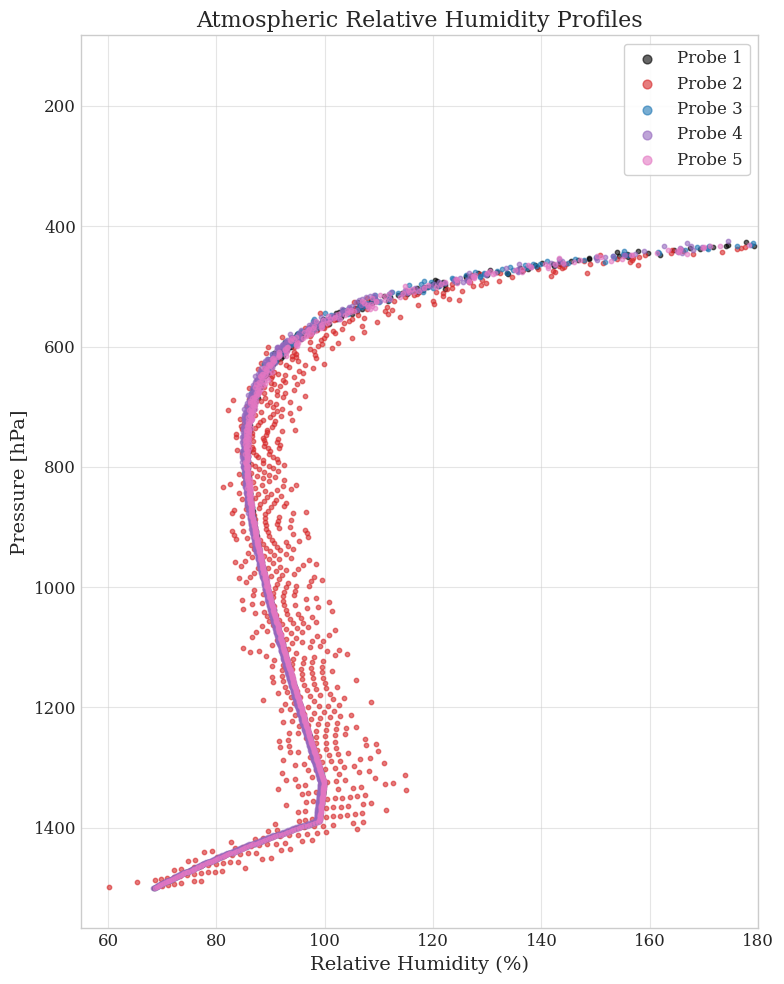

In [11]:
# -----------------------------------------------------------------------------
# 6. Relative Humidity Analysis
# -----------------------------------------------------------------------------

# Compute global Relative Humidity (%) using reconstructed thermodynamics
RH = compute_rh_profile(temperature, vapor_rho, pressure, MOLAR_MASS)

# Visualize vertical RH profiles for all descent probes
plot_humidity_profiles(RH, pressure, probe_idx_map)

## 7. Data Refinement & Quality Control
Low-level sensor noise in the upper atmosphere can introduce unphysical artifacts into the humidity retrieval. We apply a minimum detection threshold ($q_{min} = 5 \times 10^{-4}$) to the specific humidity data. We then re-calculate the hydrological parameters (PWV and RH) to ensure robustness.

In [12]:
# -----------------------------------------------------------------------------
# 7. Data Refinement: Thresholding
# -----------------------------------------------------------------------------

# Apply signal-to-noise threshold to filter specific humidity artifacts
mask = specific_humidity < HUMIDITY_THRESHOLD
specific_humidity[mask] = 0
vapor_rho[mask] = 0  # Enforce consistency in vapor density array

print(f"Data Filter Applied: Removed specific humidity < {HUMIDITY_THRESHOLD}")

# --- Recalculation ---

# 1. Re-evaluate Precipitable Water Vapor using filtered dataset
pwv_refined = calculate_precipitable_water(
    specific_humidity, pressure, g, probe_idx_map
)

# 2. Update Relative Humidity profiles based on clean vapor densities
RH_refined = compute_rh_profile(temperature, vapor_rho, pressure, MOLAR_MASS)

# Overwrite global RH array with refined values
RH = RH_refined

# --- Reporting ---
print("\n" + "=" * 60)
print("REFINED PRECIPITABLE WATER (Noise Threshold Applied)")
print_pwv_report(pwv_refined)

Data Filter Applied: Removed specific humidity < 0.0005

REFINED PRECIPITABLE WATER (Noise Threshold Applied)

PROBE      |    MASS (kg/m²) |      DEPTH (cm)
Probe 1    |           40.97 |            4.10
Probe 2    |           35.74 |            3.57
Probe 3    |           41.68 |            4.17
Probe 4    |           47.04 |            4.70
Probe 5    |           40.36 |            4.04
------------------------------------------------------------
MEAN       |           41.16 |            4.12
STD DEV    |            3.60 |            0.36



### Refined Humidity Profiles
Below we visualize the cleaned **Specific Humidity** ($q$) and **Relative Humidity** profiles side-by-side. This highlights the moisture structure of the troposphere.

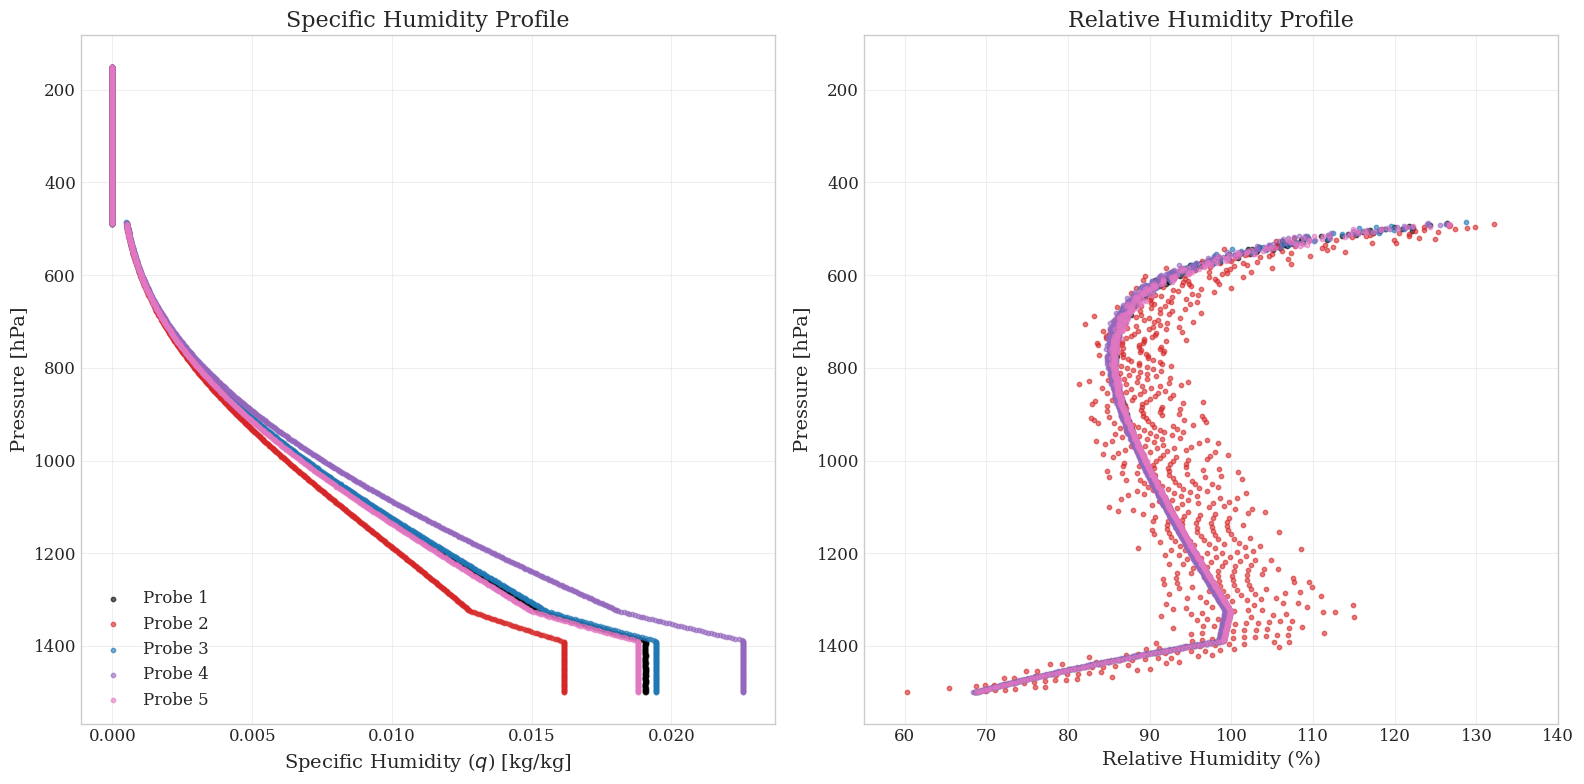

In [13]:
# -----------------------------------------------------------------------------
# 8. Humidity Visualization (Refined)
# -----------------------------------------------------------------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Assign distinct color palette for probe differentiation
colors = ["#000000", "#d62728", "#1f77b4", "#9467bd", "#e377c2"]

for i, (probe_id, indices) in enumerate(probe_idx_map.items()):
    # Isolate data segments
    p_seg = pressure[indices]
    q_seg = specific_humidity[indices]
    rh_seg = RH[indices]

    # Subplot 1: Specific Humidity
    ax1.scatter(
        q_seg, p_seg, s=10, alpha=0.6, color=colors[i], label=f"Probe {probe_id}"
    )

    # Subplot 2: Relative Humidity
    ax2.scatter(
        rh_seg, p_seg, s=10, alpha=0.6, color=colors[i], label=f"Probe {probe_id}"
    )

# Configure Subplot 1 Aesthetics
ax1.set_xlabel("Specific Humidity ($q$) [kg/kg]")
ax1.set_ylabel("Pressure [hPa]")
ax1.set_title("Specific Humidity Profile")
ax1.invert_yaxis()  # Standard atmospheric convention
ax1.legend(loc="lower left")
ax1.grid(True, alpha=0.3)

# Configure Subplot 2 Aesthetics
ax2.set_xlabel("Relative Humidity (%)")
ax2.set_ylabel("Pressure [hPa]")
ax2.set_title("Relative Humidity Profile")
ax2.invert_yaxis()
ax2.set_xlim(55, 140)  # Cap display range for clarity
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Thermodynamic Stability: Specific Heat Capacity
The specific heat capacity ($C_p$) is a critical parameter for determining the adiabatic lapse rate. We calculate the mixture $C_p$ by weighting the individual heat capacities of the constituent gases (approximating N$_2$, He, and Ar as ideal gases) by their mass fractions.

In [14]:
# -----------------------------------------------------------------------------
# 9. Thermodynamics: Specific Heat Capacity (Cp)
# -----------------------------------------------------------------------------

# 1. Calculate Component Specific Heat Capacities [J/(kg K)]
# Compute ideal gas Cp values based on degrees of freedom
cp_n2 = calculate_ideal_gas_cp(MOLAR_MASS["N2"], degrees_of_freedom=5)  # Diatomic
cp_he = calculate_ideal_gas_cp(MOLAR_MASS["He"], degrees_of_freedom=3)  # Monatomic
cp_ar = calculate_ideal_gas_cp(MOLAR_MASS["Ar"], degrees_of_freedom=3)  # Monatomic
cp_co2 = CP_CONSTANTS["CO2"]  # Empirical value
cp_h2o = CP_CONSTANTS["H2O"]  # Empirical value

# 2. Calculate Mixture Mean Cp
# Compute mass-weighted sum of constituent heat capacities
Cp_mixture = (
    specific_humidity * cp_h2o
    + co2_frac * cp_co2
    + n2_frac * cp_n2
    + he_frac * cp_he
    + ar_frac * cp_ar
)

# Validate results
print("Thermodynamics: Specific Heat Capacity Calculated.")
print(f"Mean Cp: {np.mean(Cp_mixture):.2f} J/(kg K)")
print(f"Range:   {np.min(Cp_mixture):.2f} - {np.max(Cp_mixture):.2f} J/(kg K)")

Thermodynamics: Specific Heat Capacity Calculated.
Mean Cp: 1308.40 J/(kg K)
Range:   1304.39 - 1317.80 J/(kg K)


### Specific Heat Profile
We plot the vertical variation of $C_p$. Variations in this profile indicate changes in atmospheric composition, particularly the abundance of complex molecules like H$_2$O and CO$_2$ versus monatomic gases.

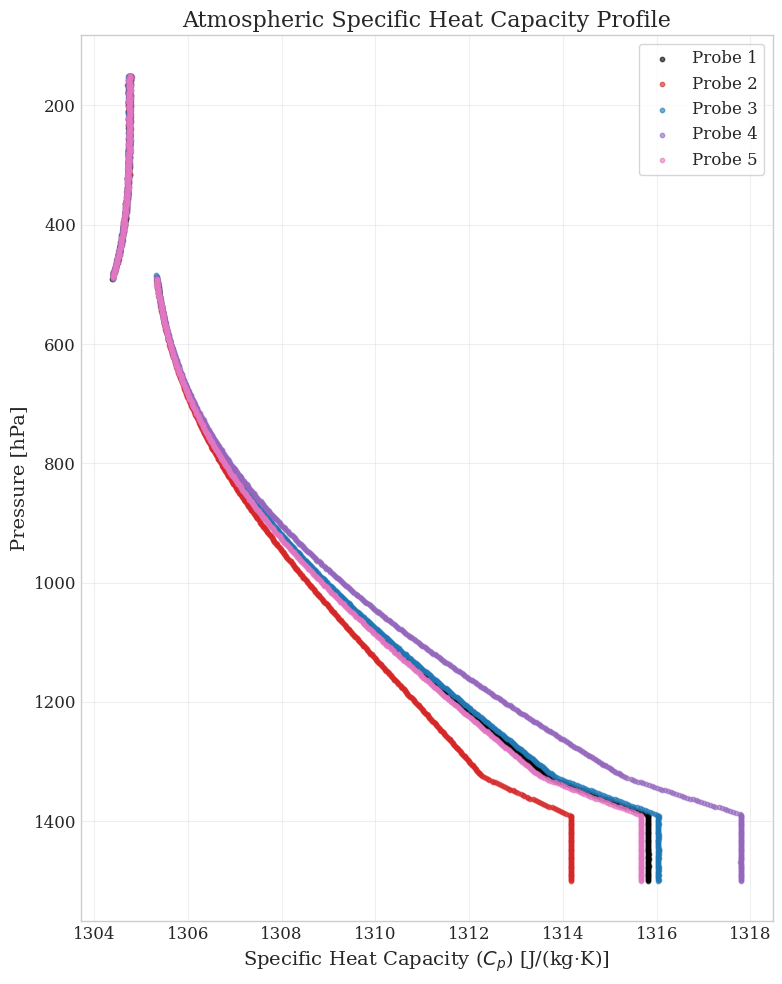

In [15]:
# -----------------------------------------------------------------------------
# 10. Thermodynamics Visualization: Specific Heat Capacity
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 10))

colors = ["#000000", "#d62728", "#1f77b4", "#9467bd", "#e377c2"]

for i, (probe_id, indices) in enumerate(probe_idx_map.items()):
    # Extract data segment
    cp_seg = Cp_mixture[indices]
    p_seg = pressure[indices]

    ax.scatter(
        cp_seg, p_seg, s=10, alpha=0.6, color=colors[i], label=f"Probe {probe_id}"
    )

ax.set_xlabel("Specific Heat Capacity ($C_p$) [J/(kg·K)]")
ax.set_ylabel("Pressure [hPa]")
ax.set_title("Atmospheric Specific Heat Capacity Profile")
ax.invert_yaxis()  # Standard atmospheric convention
ax.grid(True, alpha=0.3)
ax.legend(frameon=True)

plt.tight_layout()
plt.show()

## 9. Radiative Transfer: Optical Depth
We quantify the atmosphere's opacity to infrared radiation by calculating the vertical **Optical Depth** ($\tau$). The total optical depth from the top of the atmosphere to a pressure level $P$ is given by:

$$\tau(P) = \int_{0}^{P} \frac{\beta}{\rho g} \, dp'$$

where $\beta = \sigma n$ is the extinction coefficient, derived from the absorption cross-sections ($\sigma$) of CO$_2$ and H$_2$O.

In [16]:
# -----------------------------------------------------------------------------
# 11. Radiative Transfer: Optical Depth (Tau)
# -----------------------------------------------------------------------------

# 1. Calculate Extinction Coefficients (Beta)
# Compute beta for H2O and CO2 using the refined vapor density profile
beta_h2o, beta_co2 = calculate_extinction_coefficients(vapor_rho, co2_density_molecules)

# 2. Compute Optical Depth (Tau)
# Structure: results[species][pressure_level][probe_id]
tau_results = {"CO2": {}, "H2O": {}, "Combined": {}}

# Iterate through defined pressure levels to compute cumulative optical depth
for p_level in PRESSURE_LEVELS:
    tau_results["CO2"][p_level] = []
    tau_results["H2O"][p_level] = []
    tau_results["Combined"][p_level] = []

    for probe_id in range(1, 6):
        indices = probe_idx_map[probe_id]

        # Extract state variables for the current probe
        p_probe = pressure[indices]
        rho_probe = air_density[indices]
        beta_co2_probe = beta_co2[indices]
        beta_h2o_probe = beta_h2o[indices]

        # Integrate extinction coefficients over the pressure column
        tau_co2 = integrate_optical_depth(beta_co2_probe, rho_probe, p_probe, p_level)
        tau_h2o = integrate_optical_depth(beta_h2o_probe, rho_probe, p_probe, p_level)

        # Store constituent and total optical depths
        tau_results["CO2"][p_level].append(tau_co2)
        tau_results["H2O"][p_level].append(tau_h2o)
        tau_results["Combined"][p_level].append(tau_co2 + tau_h2o)

print("Optical Depth Calculation Complete.")

Optical Depth Calculation Complete.


### Integrated Optical Depth Results
The following tables summarize the cumulative optical depth from the top of the atmosphere down to specific pressure levels. This characterizes the penetration depth for thermal radiation across the distinct spectral bands of $CO_2$ and $H_2O$.

In [17]:
# -----------------------------------------------------------------------------
# 12. Radiative Transfer: Reporting
# -----------------------------------------------------------------------------

# Output tabulated optical depth values for each species and the combined atmosphere
print_optical_depth_table("CO2", tau_results["CO2"])
print_optical_depth_table("H2O", tau_results["H2O"])
print_optical_depth_table("CO2 + H2O", tau_results["Combined"])


CO2 Optical Depth
Pressure (hPa)       Probe 1     Probe 2     Probe 3     Probe 4     Probe 5
----------------------------------------------------------------------
1250                  3.4181      3.4193      3.4179      3.4168      3.4183
750                   1.8708      1.8708      1.8708      1.8707      1.8708
500                   1.0902      1.0902      1.0902      1.0902      1.0902
350                   0.6223      0.6223      0.6223      0.6223      0.6223
200                   0.1544      0.1544      0.1544      0.1544      0.1544


H2O Optical Depth
Pressure (hPa)       Probe 1     Probe 2     Probe 3     Probe 4     Probe 5
----------------------------------------------------------------------
1250                  1.3068      1.1779      1.3264      1.4505      1.2878
750                   0.1101      0.1067      0.1114      0.1140      0.1090
500                   0.0017      0.0017      0.0020      0.0022      0.0017
350                 0.00e+00    0.00e+00    0.00e

## 10. Targeted Analysis at 450 hPa
We perform a sensitivity analysis at the 450 hPa pressure level using a specific water vapor absorption cross-section ($\sigma_{H2O} = 7.5 \times 10^{-29} \, \text{m}^2$). This helps characterize the opacity and thermal state of the middle atmosphere.

In [18]:
# -----------------------------------------------------------------------------
# 13. Radiative Transfer: Targeted Analysis at 450 hPa
# -----------------------------------------------------------------------------

# 1. Calculate Local Extinction Coefficient
# Re-evaluate number density and beta using the specific cross-section
M_h2o_kg = MOLAR_MASS["H2O"] * 1e-3
n_h2o = (vapor_rho * Avogadro) / M_h2o_kg
beta_h2o_450 = SIGMA_H2O_SPECIFIC * n_h2o

# 2. Probe Analysis
results_450 = []

for probe_id in range(1, 6):
    indices = probe_idx_map[probe_id]

    # Extract Probe Data
    p_probe = pressure[indices]
    rho_probe = air_density[indices]
    beta_probe = beta_h2o_450[indices]
    vapor_probe = vapor_rho[indices]
    t_probe = temperature[indices]

    # Filter: Integrate only layers above target pressure where vapor is present
    mask = (p_probe <= TARGET_PRESSURE) & (vapor_probe > 0)

    # Calculate Optical Depth via Trapezoidal Integration
    if np.sum(mask) > 1:
        integrand = beta_probe[mask] / (rho_probe[mask] * g)
        p_pa = p_probe[mask] * 100.0  # Convert hPa to Pa
        tau = np.trapezoid(integrand, p_pa)
    else:
        tau = 0.0

    # Extract Temperature at exactly TARGET_PRESSURE for correlation
    idx_target = np.where(p_probe == TARGET_PRESSURE)[0]

    if len(idx_target) > 0:
        t_val = t_probe[idx_target[0]]
    else:
        t_val = np.nan

    results_450.append({"id": probe_id, "tau": tau, "temp": t_val})

print(f"Analysis at {TARGET_PRESSURE} hPa complete.")

Analysis at 450.0 hPa complete.


### Targeted Analysis Results
The following report summarizes the optical depth and local temperature for each probe at the reference pressure level of $P = 450 \text{ hPa}$. The variations in temperature at this isobar indicate potential atmospheric dynamics or horizontal inhomogeneity.

In [19]:
# -----------------------------------------------------------------------------
# 14. Reporting: 450 hPa Summary
# -----------------------------------------------------------------------------

# Table Header
print(f"\n{'=' * 70}")
print(f"\033[1mOptical Depth and Temperature at {TARGET_PRESSURE} hPa\033[0m")
print(f"\033[1m(H₂O Cross-Section: {SIGMA_H2O_SPECIFIC:.2e} m²/molecule)\033[0m")
print(f"{'=' * 70}")
print(f"{'Probe':<12}{'τ (H₂O)':>20}{'Temperature (K)':>25}")
print("-" * 70)

# Table Rows
temps = []
for res in results_450:
    t_val = res["temp"]
    temps.append(t_val)
    print(f"Probe {res['id']:<6}{res['tau']:>20.4e}{t_val:>25.2f}")

print("=" * 70)

# Summary Statistics
temps = np.array(temps)
print(f"\n\033[1mTemperature Statistics at {TARGET_PRESSURE} hPa\033[0m")
print("-" * 40)
print(f"Mean:    {np.mean(temps):.2f} K")
print(f"Std Dev: {np.std(temps):.2f} K")
print(f"Min:     {np.min(temps):.2f} K (Probe {np.argmin(temps) + 1})")
print(f"Max:     {np.max(temps):.2f} K (Probe {np.argmax(temps) + 1})")
print(f"Range:   {np.max(temps) - np.min(temps):.2f} K")


Optical Depth and Temperature at 450.0 hPa
(H₂O Cross-Section: 7.50e-29 m²/molecule)
Probe                    τ (H₂O)          Temperature (K)
----------------------------------------------------------------------
Probe 1               0.0000e+00                   228.63
Probe 2               0.0000e+00                   228.20
Probe 3               0.0000e+00                   228.73
Probe 4               0.0000e+00                   228.73
Probe 5               0.0000e+00                   228.53

Temperature Statistics at 450.0 hPa
----------------------------------------
Mean:    228.56 K
Std Dev: 0.20 K
Min:     228.20 K (Probe 2)
Max:     228.73 K (Probe 3)
Range:   0.53 K


## 7. Potential Temperature ($\theta$)
Potential temperature is conserved for air parcels undergoing adiabatic processes. It is defined as the temperature a parcel would have if brought adiabatically to a reference surface pressure ($P_{ref}$).

$$\theta = T \left( \frac{P_{ref}}{P} \right)^{1 - 1/\gamma}$$

where $\gamma = C_p / C_v$ is the adiabatic index. Constant $\theta$ with height indicates a well-mixed, neutral layer, while increasing $\theta$ indicates stratification.

In [20]:
# -----------------------------------------------------------------------------
# 15. Thermodynamics: Potential Temperature (Theta)
# -----------------------------------------------------------------------------

# 1. Data Cleaning: Filter Sensor Errors
# Probe 2 exhibits unphysical negative temperatures (-1000) at high pressures
# Mask invalid data to prevent propagation of errors
valid_data_mask = temperature > 0
temp_clean = temperature.copy()
temp_clean[~valid_data_mask] = np.nan

# 2. Calculate Specific Gas Constant [J/(kg K)]
# Derive specific gas constant for the mixture from mean molar mass
R_specific_mix = R / (mix_molar_mass * 1e-3)

# 3. Calculate Adiabatic Index (Gamma)
# Use Mayer's Relation (Cp - Cv = R_specific) to find Cv
Cv_mixture = Cp_mixture - R_specific_mix
gamma_mixture = Cp_mixture / Cv_mixture

# 4. Define Reference Pressure
# Use surface pressure of Probe 1 as the standard reference level
idx_surface_p1 = probe_idx_map[1][-1]
P_ref = pressure[idx_surface_p1]

# 5. Calculate Potential Temperature
# Apply Poisson's Equation: theta = T * (P_ref / P)^(1 - 1/gamma)
exponent = 1.0 - (1.0 / gamma_mixture)
potential_temp = temp_clean * (P_ref / pressure) ** exponent

# Output validation statistics
print("Potential Temperature Calculated.")
print(f"Reference Pressure: {P_ref:.2f} hPa")
print(f"Mean Gamma: {np.nanmean(gamma_mixture):.4f}")
print(f"Data Cleaning: {np.sum(~valid_data_mask)} invalid data points removed.")

Potential Temperature Calculated.
Reference Pressure: 1500.00 hPa
Mean Gamma: 1.4743
Data Cleaning: 1 invalid data points removed.


### Potential Temperature Profile
The vertical profile of $\theta$ allows us to identify atmospheric stability regimes. A transition from constant $\theta$ (convective zone) to rapidly increasing $\theta$ (stratified zone) typically marks the **Tropopause**.

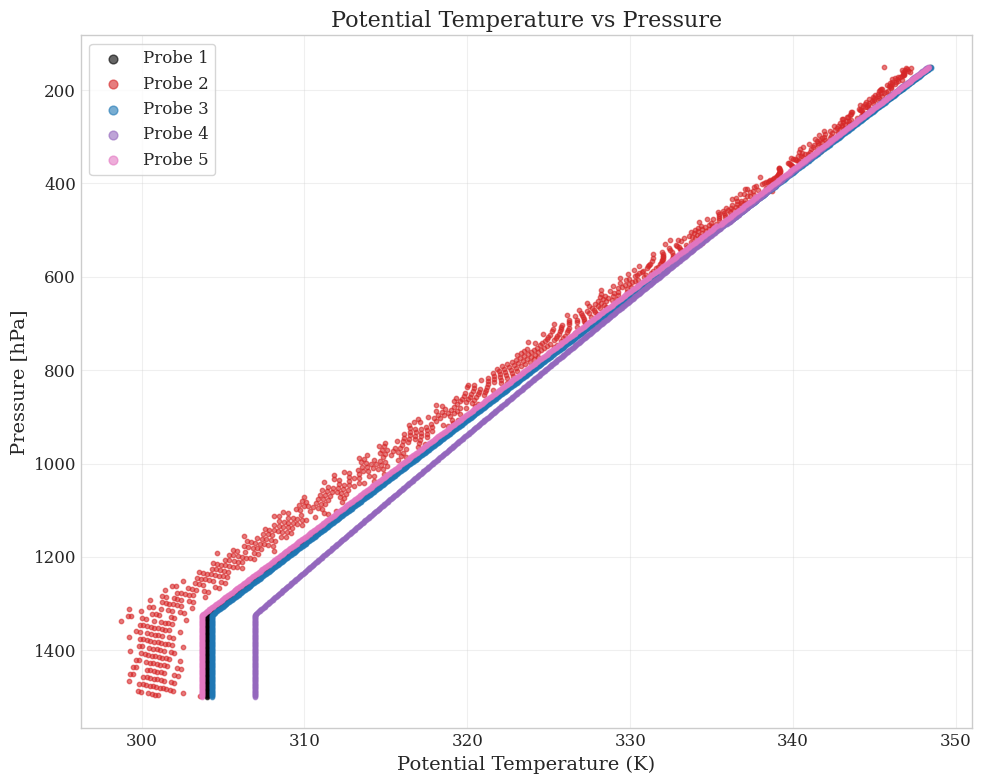

In [21]:
# -----------------------------------------------------------------------------
# 16. Visualization: Potential Temperature
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 8))

colors = ["#000000", "#d62728", "#1f77b4", "#9467bd", "#e377c2"]

for i, (probe_id, indices) in enumerate(probe_idx_map.items()):
    # Extract potential temperature and pressure data
    theta_seg = potential_temp[indices]
    p_seg = pressure[indices]

    # Plot profile (NaN values are automatically handled)
    ax.scatter(
        theta_seg, p_seg, s=10, color=colors[i], label=f"Probe {probe_id}", alpha=0.6
    )

ax.set_xlabel("Potential Temperature (K)")
ax.set_ylabel("Pressure [hPa]")
ax.set_title("Potential Temperature vs Pressure")
ax.invert_yaxis()  # Standard atmospheric convention
ax.grid(True, alpha=0.3)
ax.legend(frameon=True, markerscale=2)

plt.tight_layout()

fig.savefig(fig_dir / "temperature_vs_pressure.pdf", bbox_inches="tight")
fig.savefig(fig_dir / "temperature_vs_pressure.svg", bbox_inches="tight")

plt.show()

## 8. Dry Adiabatic Lapse Rate
We compute the theoretical **Dry Adiabatic Lapse Rate** ($\Gamma_d$), which describes the rate of cooling for a rising dry air parcel:
$$\Gamma_d = \frac{g}{C_p}$$
This serves as a baseline for assessing atmospheric stability against convection.

In [22]:
# -----------------------------------------------------------------------------
# 17. Stability Analysis: Dry Adiabatic Lapse Rate
# -----------------------------------------------------------------------------

# 1. Calculate Theoretical Lapse Rate [K/km]
# Formula: Gamma_d = g / Cp
# Unit conversion: [m/s^2] / [J/(kg K)] = [K/m] -> [K/km] (* 1000)
da_lapse_rate = (g / Cp_mixture) * 1000.0

# Output mean stability parameter
print("Stability Analysis: Dry Adiabatic Lapse Rate Calculated.")
print(f"Mean Lapse Rate: {np.mean(da_lapse_rate):.2f} K/km")

Stability Analysis: Dry Adiabatic Lapse Rate Calculated.
Mean Lapse Rate: 15.29 K/km


### Stability Comparison
We compare the theoretical lapse rate against pressure. In regions where the actual temperature gradient exceeds $\Gamma_d$, the atmosphere is unstable to convection.

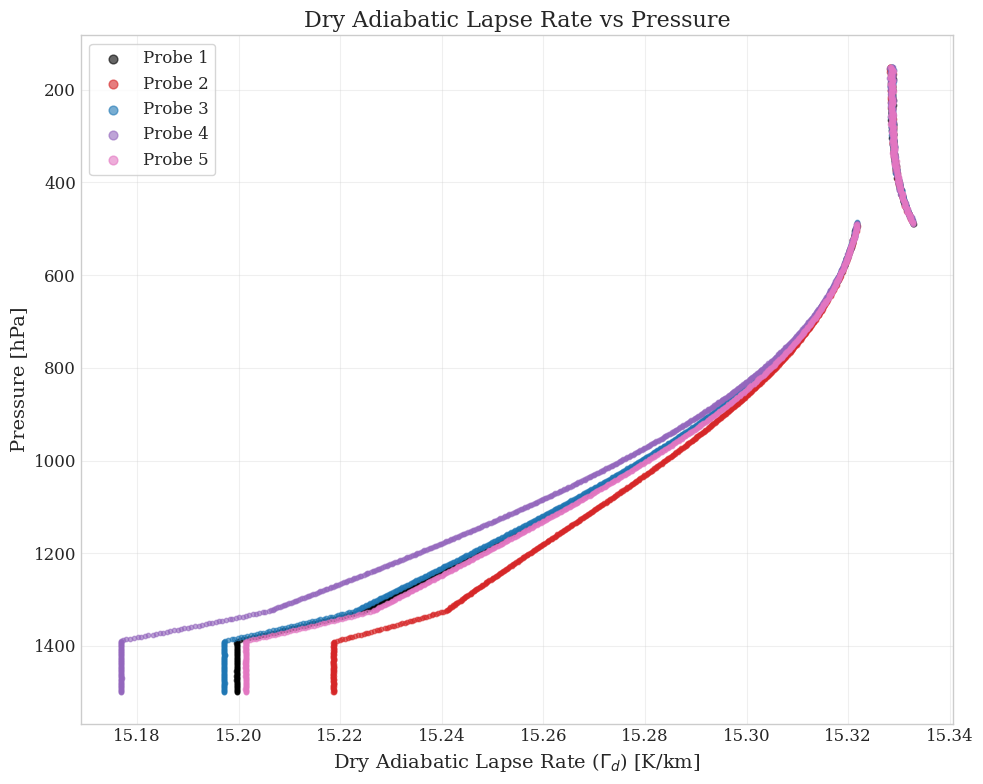

In [23]:
# -----------------------------------------------------------------------------
# 18. Visualization: Dry Adiabatic Lapse Rate
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 8))

# Assign distinct color palette for probe differentiation
colors = ["#000000", "#d62728", "#1f77b4", "#9467bd", "#e377c2"]

for i, (probe_id, indices) in enumerate(probe_idx_map.items()):
    # Extract lapse rate and pressure data
    lapse_seg = da_lapse_rate[indices]
    p_seg = pressure[indices]

    # Plot theoretical lapse rate profile
    ax.scatter(
        lapse_seg, p_seg, s=10, color=colors[i], label=f"Probe {probe_id}", alpha=0.6
    )

    # Configure plot aesthetics (using raw string for LaTeX compatibility)
    ax.set_xlabel(r"Dry Adiabatic Lapse Rate ($\Gamma_d$) [K/km]")
    ax.set_ylabel("Pressure [hPa]")
    ax.set_title("Dry Adiabatic Lapse Rate vs Pressure")
    ax.invert_yaxis()  # Standard atmospheric convention
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True, markerscale=2)

plt.tight_layout()
plt.show()

## 11. Global Hydrological Cycle
Finally, we estimate the global precipitation rate and the atmospheric residence time of water vapor. We assume a steady-state energy balance where the latent heat flux from the surface balances the energy required for global evaporation.

**Residence Time ($\tau_{res}$):**
$$\tau_{res} = \frac{M_{total}}{\dot{M}_{precip}}$$

In [24]:
# -----------------------------------------------------------------------------
# 19. Global Water Cycle & Uncertainty Analysis
# -----------------------------------------------------------------------------

# 1. Calculate Global Hydrological Parameters
# Derive precipitation rate and residence time using refined PWV data
P_rate, Tau, pwv_array = calculate_global_water_cycle(
    pwv_refined, ABSORBED_SW_FLUX, LATENT_HEAT_FRAC, L_VAPORIZATION
)

# 2. Uncertainty Propagation
# Calculate relative uncertainties for input parameters
rel_u_sw = U_SW_FLUX / ABSORBED_SW_FLUX
rel_u_frac = U_LH_FRAC / LATENT_HEAT_FRAC
rel_u_lv = U_L_VAP / L_VAPORIZATION

# Propagate error for Precipitation Rate (P = A * B / C)
# Relative Uncertainty = sqrt( (dA/A)^2 + (dB/B)^2 + (dC/C)^2 )
rel_u_precip = np.sqrt(rel_u_sw**2 + rel_u_frac**2 + rel_u_lv**2)
u_P_rate = P_rate * rel_u_precip

# Propagate error for Residence Time (Tau = Mass / P)
# Mass uncertainty is approximated by the spatial variability (std dev) of PWV measurements
rel_u_mass = np.std(pwv_array) / np.mean(pwv_array)
rel_u_tau = np.sqrt(rel_u_mass**2 + rel_u_precip**2)
u_Tau = Tau * rel_u_tau

# --- Final Report ---
print("=" * 60)
print("GLOBAL HYDROLOGICAL CYCLE SUMMARY")
print("=" * 60)
print(f"Global-Mean Precip Rate:    {P_rate:.4f} ± {u_P_rate:.4f} mm/hour")
print(f"Water Vapor Residence Time: {Tau:.2f} ± {u_Tau:.2f} Earth days")
print("-" * 60)
print("Uncertainty Budget:")
print(f"  - Precip Rate Relative Error: {rel_u_precip * 100:.1f}%")
print(f"  - Spatial Variability (PWV):  {rel_u_mass * 100:.1f}%")
print("=" * 60)

GLOBAL HYDROLOGICAL CYCLE SUMMARY
Global-Mean Precip Rate:    0.0864 ± 0.0127 mm/hour
Water Vapor Residence Time: 19.85 ± 3.40 Earth days
------------------------------------------------------------
Uncertainty Budget:
  - Precip Rate Relative Error: 14.7%
  - Spatial Variability (PWV):  8.8%
